In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import torch
from datetime import datetime, timezone
import logging

logging.basicConfig(
    level=logging.INFO,  # Set the logging level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Format for the log messages
    handlers=[
        logging.StreamHandler()  # Log to the console
    ]
)

%reload_ext autoreload
%autoreload 2
from data.raw.retrievers.alpaca_markets_retriever import AlpacaMarketsRetriever
from config.constants import *
from data.processed.dataset_creation import DatasetCreator
from data.processed.indicators import *
from data.processed.targets import Balanced3ClassClassification
from data.processed.normalization import ZScoreOverWindowNormalizer, ZScoreNormalizer, MinMaxNormalizer
from data.processed.dataset_pytorch import DatasetPytorch
from modeling.trainer import Trainer
from modeling.evaluate import evaluate_lgb_regressor, evaluate_torch_regressor, evaluate_torch_regressor_multiasset
# from observability.mlflow_integration import log_experiment

from modeling.rl.environment import PortfolioEnvironment
from modeling.rl.state import State
from modeling.rl.agent import RlAgent
from modeling.rl.algorithms.policy_gradient import PolicyGradient
from modeling.rl.actors.actor import RlActor, FullyConnectedBackend, TransformerBackend
from modeling.rl.actors.signal_predictor_actor import SignalPredictorActor
from modeling.rl.actors.high_energy_low_friction_actor import HighEnergyLowFrictionActor
from modeling.rl.actors.xsmom_actor import XSMomActor
from modeling.rl.actors.tsmom_actor import TSMomActor
from modeling.rl.actors.blsw_actor import BLSWActor
from modeling.rl.trajectory_dataset import TrajectoryDataset
from modeling.rl.metrics import MetricsCalculator, DEFAULT_METRICS
from modeling.rl.reward import EstimatedReturnReward
from modeling.rl.loss import SumLogReturnLoss
from modeling.rl.visualization.wealth_plot import plot_cumulative_wealth
from modeling.rl.visualization.position_plot import plot_position_heatmap
from config.experiments.cur_experiment import config

torch.backends.cudnn.benchmark = config.train_config.cudnn_benchmark

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [3]:
str(config.data_config.frequency)

'1Day'

In [4]:
from data.raw.retrievers.stooq_retriever import StooqRetriever
retriever = StooqRetriever()
retrieval_result = retriever.bars(end=datetime(2008, 9, 1, tzinfo=timezone.utc))

# retriever = AlpacaMarketsRetriever(download_from_gdrive=False, timeframe=config.data_config.frequency)

# retrieval_result = retriever.bars_with_quotes(
#     symbol_or_symbols=config.data_config.symbol_or_symbols, 
#     start=config.data_config.start, 
#     end=config.data_config.end)

2025-08-18 19:21:10,971 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-18 19:21:13,615 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-18 19:21:13,856 - INFO - v_us_d.csv has no data prior to 1999-06-01


In [5]:
retrieval_result['AAPL']

,date,open,high,low,close,volume
3722,1999-06-01 17:00:00+00:00,0.338530,0.340943,0.334065,0.337307,547132917
3723,1999-06-02 17:00:00+00:00,0.334676,0.360537,0.331029,0.350306,618377277
3724,1999-06-03 17:00:00+00:00,0.352712,0.361147,0.352396,0.356890,579751123
3725,1999-06-04 17:00:00+00:00,0.358181,0.362369,0.355402,0.362072,437541537
3726,1999-06-07 17:00:00+00:00,0.362072,0.368635,0.357520,0.367975,496411151
...,...,...,...,...,...,...
6044,2008-08-25 17:00:00+00:00,5.293620,5.302980,5.165990,5.192710,574712726
6045,2008-08-26 17:00:00+00:00,5.196460,5.262760,5.194670,5.225210,528649681
6046,2008-08-27 17:00:00+00:00,5.210740,5.288870,5.181170,5.256660,565587801
6047,2008-08-28 17:00:00+00:00,5.275480,5.303670,5.199290,5.228390,511393399


In [6]:
config.data_config.train_set_last_date

datetime.datetime(2007, 9, 1, 0, 0, tzinfo=datetime.timezone.utc)

In [7]:
dataset_creator = DatasetCreator(
    features=config.data_config.features,
    target=config.data_config.target,
    normalizer=config.data_config.normalizer,
    missing_values_handler=config.data_config.missing_values_handler,
    train_set_last_date=config.data_config.train_set_last_date, 
    cutoff_time=config.data_config.cutoff_time,
    in_seq_len=config.data_config.in_seq_len,
    multi_asset_prediction=config.data_config.multi_asset_prediction,
)

X_train, y_train, next_return_train, spread_train, volatility_train, X_test, y_test, next_return_test, spread_test, volatility_test = dataset_creator.create_dataset_numpy(retrieval_result)
X_train.shape, y_train.shape, next_return_train.shape, spread_train.shape, volatility_train.shape, X_test.shape, y_test.shape, next_return_test.shape, spread_test.shape, volatility_test.shape

2025-08-18 19:21:14,461 - INFO - Processing AAPL …
2025-08-18 19:21:14,524 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 19:21:14,525 - INFO - Spread has 0 NaNs
2025-08-18 19:21:14,532 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 19:21:14,539 - INFO - Processing AMGN …
2025-08-18 19:21:14,596 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 19:21:14,608 - INFO - Spread has 0 NaNs
2025-08-18 19:21:14,615 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 19:21:14,623 - INFO - Processing AMZN …
2025-08-18 19:21:14,677 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 19:21:14,677 - INFO - Spread has 0 NaNs
2025-08-18 19:21:14,694 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 19:21:14,703 - INFO - Processing AXP …
2025-08-18 19:21:14,768 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
20

((2008, 27, 60, 15),
 (2008, 27),
 (2008, 27),
 (2008, 27),
 (2008, 27),
 (191, 27, 60, 15),
 (191, 27),
 (191, 27),
 (191, 27),
 (191, 27))

In [8]:
np.sqrt(((y_train - np.ones_like(y_train) * 0.5)**2).mean())

0.35246432

In [9]:
np.sqrt(((y_test - np.ones_like(y_test) * 0.5)**2).mean())

0.38802052

In [10]:
y_train.mean(), y_test.mean()

(0.50010604, 0.48017257)

In [11]:
train_loader = DatasetPytorch(X_train, y_train, learning_task='regression').as_dataloader(
    batch_size=config.train_config.batch_size,
    shuffle=config.train_config.shuffle,
    num_workers=config.train_config.num_workers,
    prefetch_factor=config.train_config.prefetch_factor,
    pin_memory=config.train_config.pin_memory,
    persistent_workers=config.train_config.persistent_workers,
    drop_last=config.train_config.drop_last
)
test_loader = DatasetPytorch(X_test, y_test, learning_task='regression').as_dataloader(
    batch_size=config.train_config.batch_size,
    shuffle=config.train_config.shuffle,
    num_workers=config.train_config.num_workers,
    prefetch_factor=config.train_config.prefetch_factor,
    pin_memory=config.train_config.pin_memory,
    persistent_workers=config.train_config.persistent_workers,
    drop_last=config.train_config.drop_last
)

In [12]:
model = config.model_config.model
model

TemporalSpatial(
  (lstm): LSTM(15, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (spatial_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [13]:
# model.load_state_dict(torch.load('../modeling/checkpoints/best_tech_1h_model.pth'))

In [14]:
config

ExperimentConfig(data_config=DataConfig(symbol_or_symbols=['AAPL', 'AMD', 'BABA', 'BITU', 'C', 'CSCO', 'DAL', 'DIA', 'GLD', 'GOOG', 'IJR', 'MARA', 'MRVL', 'MU', 'NEE', 'NKE', 'NVDA', 'ON', 'PLTR', 'PYPL', 'QLD', 'QQQ', 'QQQM', 'RKLB', 'RSP', 'SMCI', 'SMH', 'SOXL', 'SOXX', 'SPXL', 'SPY', 'TMF', 'TNA', 'TQQQ', 'TSLA', 'UBER', 'UDOW', 'UPRO', 'VOO', 'WFC', 'XBI', 'XLC', 'XLE', 'XLI', 'XLK', 'XLU', 'XLV', 'XLY', 'XOM', 'XRT'], frequency=<alpaca.data.timeframe.TimeFrame object at 0x000002CC5E37FB00>, start=datetime.datetime(2024, 6, 1, 0, 0, tzinfo=datetime.timezone.utc), end=datetime.datetime(2025, 6, 1, 0, 0, tzinfo=datetime.timezone.utc), features={'log_ret': <function <lambda> at 0x000002CC5E39A0C0>, 'hl_range': <function <lambda> at 0x000002CC5E39A160>, 'close_open': <function <lambda> at 0x000002CC5E3B0900>, 'vol_delta': <function <lambda> at 0x000002CC5E3B09A0>, 'EMA_fast': <data.processed.indicators.EMA object at 0x000002CC5E39D7F0>, 'EMA_slow': <data.processed.indicators.EMA object

In [15]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    loss_fn=config.train_config.loss_fn,
    optimizer=config.train_config.optimizer,
    scheduler=config.train_config.scheduler,
    num_epochs=config.train_config.num_epochs,
    device=config.train_config.device,
    metrics=config.train_config.metrics,
    save_path=config.train_config.save_path,
    early_stopping_patience=config.train_config.early_stopping_patience,
)

In [16]:
# 0.1154
# 0.3397

In [17]:
model, history = trainer.train()

2025-08-18 19:21:23,401 - INFO - Epoch 1/20
2025-08-18 19:21:36,936 - INFO - Train Loss: 0.2791      
2025-08-18 19:21:36,937 - INFO - Train Rmse: 0.5268
2025-08-18 19:21:36,938 - INFO - Val   Loss: 0.1650
2025-08-18 19:21:36,938 - INFO - Val   Rmse: 0.4061
2025-08-18 19:21:36,939 - INFO - 
2025-08-18 19:21:36,945 - INFO - Epoch 2/20
2025-08-18 19:21:39,765 - INFO - Train Loss: 0.1608      
2025-08-18 19:21:39,767 - INFO - Train Rmse: 0.4003
2025-08-18 19:21:39,769 - INFO - Val   Loss: 0.1481
2025-08-18 19:21:39,770 - INFO - Val   Rmse: 0.3848
2025-08-18 19:21:39,771 - INFO - 
2025-08-18 19:21:39,775 - INFO - Epoch 3/20
2025-08-18 19:21:42,538 - INFO - Train Loss: 0.1344      
2025-08-18 19:21:42,539 - INFO - Train Rmse: 0.3663
2025-08-18 19:21:42,540 - INFO - Val   Loss: 0.1427
2025-08-18 19:21:42,541 - INFO - Val   Rmse: 0.3778
2025-08-18 19:21:42,542 - INFO - 
2025-08-18 19:21:42,548 - INFO - Epoch 4/20
2025-08-18 19:21:45,372 - INFO - Train Loss: 0.1356      
2025-08-18 19:21:45,37

In [ ]:
train_trajectory_loader = TrajectoryDataset(X_train, next_return_train, spread_train, volatility_train, trajectory_length=20).as_dataloader(
    batch_size=8, 
    shuffle=True,
    num_workers=8,
    prefetch_factor=4,
    pin_memory=True,
    persistent_workers=True,
    drop_last=True,
)
val_trajectory_loader = TrajectoryDataset(X_test, next_return_test, spread_test, volatility_test, trajectory_length=20).as_dataloader(
    batch_size=8, 
    shuffle=False,
    num_workers=8,
    prefetch_factor=4,
    pin_memory=True,
    persistent_workers=True,
    drop_last=True,
)

In [23]:
env = PortfolioEnvironment(
    reward_function=EstimatedReturnReward(fee=0.001, spread_multiplier=0.0),
)

backend = FullyConnectedBackend(
    n_assets=len(config.data_config.symbol_or_symbols),
    hidden_dim=128,
    num_layers=2, 
    dropout=0.1,
    use_layer_norm=False,
)

actor = RlActor(
    model, 
    backend,
    n_assets=len(config.data_config.symbol_or_symbols),
    train_signal_predictor=False, 
    exploration_eps=0.0
).to(device)

signal_predictor_actor = SignalPredictorActor(
    model, 
    trade_asset_count=1,
    train_signal_predictor=False
).to(device)

rl_agent = RlAgent(
    actor, 
    env,
    single_action_per_trajectory=True
)

metrics_calculator = MetricsCalculator(
    metrics=DEFAULT_METRICS
)

policy_gradient = PolicyGradient(
    rl_agent, 
    train_trajectory_loader, 
    val_trajectory_loader, 
    metrics_calculator=metrics_calculator,
    optimizer=torch.optim.AdamW(
        [p for p in actor.parameters() if p.requires_grad], 
        lr=1e-3,
        weight_decay=1e-5,
        amsgrad=True),
    scheduler=None,
    loss_fn=SumLogReturnLoss(use_baseline=False),
    num_epochs=10,
    device=device
)

In [24]:
epoch_loss, realized_returns_signal_predictor, actions_signal_predictor = policy_gradient.evaluate(signal_predictor_actor)

Val Epoch 0/10:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-18 19:23:26,364 - INFO - [PolicyGradient] [VAL] Epoch 0/10 — CumulativeReturn: 0.2954, MeanReturnPercentage: 0.1947, ARR: 52395011269497507060282352897801635624327242826878396613749496700400427859968.0000, AVOL: 5.4086, MDD: -0.1438, ASR: 9687364225378609275946845908100203351307257879971971273486125032667380449280.0000, CR: 364262411006904434044361676297358874671692916646914007195951503703093102510080.0000, DDR: 14919701415770100294539904669697921458543157081109575823675904261810116624384.0000


[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0324


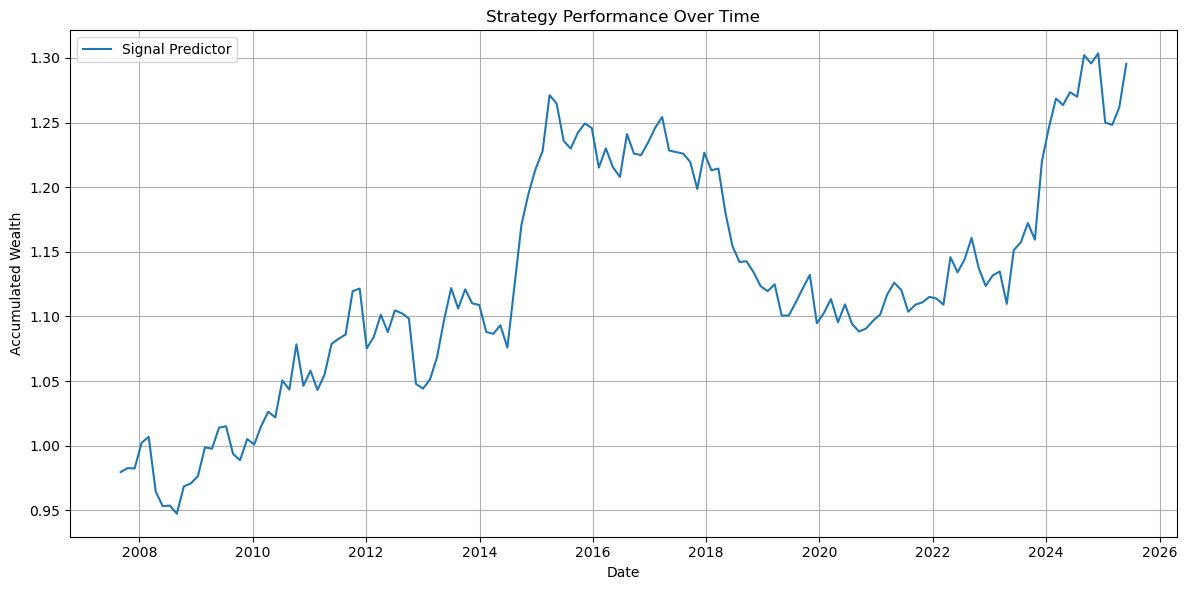

In [25]:
plot_cumulative_wealth(
    returns_dict={
        'Signal Predictor': realized_returns_signal_predictor,
    }, 
    start_time=config.data_config.train_set_last_date, 
    end_time=config.data_config.end
)

In [24]:
import copy  # Local import to avoid polluting global namespace unnecessarily
state_dict = (
    model.module.state_dict()
        if isinstance(model, torch.nn.DataParallel)
    else model.state_dict()
)

# Keep a local copy of the best weights so we can return the best model
# after training finishes, without needing to reload from disk.
best_model_state = copy.deepcopy(state_dict)

# Persist to disk if a save_path was provided
torch.save(state_dict, "best_model.pth")

In [20]:
log_experiment(
    config=config, 
    model=model, 
    history=history,
    input_data_sample=next(iter(train_loader))[0].to(trainer.device))

2025/06/26 15:35:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'LSTM Default' already exists. Creating a new version of this model...
2025/06/26 15:35:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM Default, version 10


🏃 View run gentle-loon-699 at: http://127.0.0.1:8080/#/experiments/439216085822475480/runs/54deb1104660468d9ffb4e7e278e9cfb
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/439216085822475480


Created version '10' of model 'LSTM Default'.


In [10]:
evaluate_lgb_regressor(X_train, y_train, X_test, y_test, next_return_test)

c:\Users\ikurnosau\anaconda3\envs\mldl\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9435
[LightGBM] [Info] Number of data points in the train set: 7371, number of used features: 37
[LightGBM] [Info] Start training from score 0.497863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\ikurnosau\anaconda3\envs\mldl\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ikurnosau\anaconda3\envs\mldl\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
